# Midterm Exam: Michael Beckinghausen | mbecking

# Problem #1: Value Iteration Optimization in a Grid World

In this problem we have defined a grid world with a start state at (0,0) represented by the green square. We have a terminal state represented by the red square at (7,7). All of the white squares are spaces that we can be in and the black region is not an available state. This allows us to set up our state space:

**State Space:**

I know that the space state is all of the non black spaces, thus we can set up a conditional state space. First, we will represent a state as a tuple of ints (int,int) that represent the position on the board starting from the upper left green corner (0,0) to the lower right red corner (7,7). 

Define: Board Size = n (and ranges from 0 to n).  In this case Board size = 7

Define Function: **Is_Space(i,j) $\to$ (i,j) or None**. This function takes in a state space and if it is a non black square it returns the (i,j) state, but if it is a black square it returns none and is not added to the state space. Thus we can now represent the entire state space.    

For any combination of $(i = 0 \to 7, j = 0 \to 7,)$ 

   $\mathcal{S} = \{ (0,0),$ **Is_Space(i,j)** $ (7,7)\}$
   
   (0,0) and (7,7) are specifically included in this since they are the start and end states and visually it looks nicer to show the range, I get that how this is set up the (0,0) and (7,7) term would show up twice in the state space, so please assume that either the function checks to see if the state already exists or take the state space to be $\mathcal{S} = \{ $ **Is_Space(i,j)** $\}$ to remove any of the confusion.
   
$\mathcal{T} = (7,7) $ Set of terminal states

**Action Space:**

From the problem statement we know that the possible actions that we can take are (Up, Down, Left, Right) and these represents the actions that take us to states that are adjacent. However, in this grid world we know that not all of the states can move any direction. In fact most states can only move 2 directions, so we need to set up another function that tells us what moves we can do given that we are in a specific state: 

All Possible actions $\mathcal{A} = \{Up,Down,Left,Right\}$

Define function: **Possible_actions(s) $\to \mathcal{A}_{pos} \subset \mathcal{A}$** Where the function returns a subset of actions that is less than all the possible actions. This specifically applies to this grid since none of the states have the possibilites of doing all 4 actions. The funciton works by checking a move and determining if the new state that the move takes you to is part of the state space. if it is then that is an acceptable action. If the move takes you to a black square then it is not an acceptable action. 

Actions per state: $\mathcal{A}(s) = $ **Possible_actions(s)**

**State Transition Probability & State Action Transition Probability** 

Since we know that for each action that we can take only leads to 1 new state, the transition probability for taking that action given that it is one of the acceptable actions for that state is always 1 once we have taken that action. 

If s' is adjacent to s in the direction of action a then:

$\mathcal{P}^a(s'|s) = {1}$ for all $a \in \mathcal{A}_{pos}$

else:

$\mathcal{P}(s'|s) = {0}$

once we take an action the probability that we transiiton into a single specific state according to the move is 1. however, if s' is not adjacent to s then there is no possible way to transition into it

Separately, there is also a state transition probability of the markov process with equal probability of moving into any ajacent available space. thus:

$\mathcal{P}(s'|s) = \frac{1}{\textrm{Number of Possible actions(s)}}$

**Reward Transition Function (Each move obtains a reward)**

$\mathcal{R}^a(s'|s) = -1 $ and $\gamma = 1$

Any transition is a reward of -1 so that the more moves we do, the worse our reward. Thus we maximize the reward by taking as few steps as possible and thus the shortest path

**Reward Transition Function (Only a move into the terminal state obtains a reward, but it is discounted)**

$\mathcal{R}^a(s'|s) = 1 $ if $s' \in  \mathcal{T}$ and $\gamma < 1 $

The pick for gamma is pretty arbitrary, but it just has to be less than 1 and greater or equal to 0.

### Import Modules To begin Coding:

In [13]:
import sys
sys.path.append("../../RL-book")
from dataclasses import dataclass
from typing import Tuple, Dict
from rl.markov_decision_process import FiniteMarkovDecisionProcess, MarkovDecisionProcess
from rl.markov_decision_process import FinitePolicy, StateActionMapping
from rl.markov_process import FiniteMarkovProcess, FiniteMarkovRewardProcess
from rl.distribution import Categorical, Constant
from scipy.stats import poisson
import numpy as np
import numpy.linalg as LA
from more_itertools import distinct_permutations
import matplotlib.pyplot as plt
from rl.dynamic_programming import value_iteration, policy_iteration, policy_iteration_result

from IPython.core.display import display, HTML
display(HTML("<style>.container{width:90%!important;}"))

In [14]:
P = np.random.rand(4,4)
R = np.full(4,1)

gamma = 0
print (P)
print (R)

X = np.full((4,4),1)
print (X)

print (LA.eig(X))

[[0.63332177 0.29365131 0.57836055 0.57909761]
 [0.42391535 0.82100709 0.19447106 0.15998904]
 [0.44091167 0.4649787  0.27752799 0.24767538]
 [0.63307155 0.36501059 0.98763594 0.57297152]]
[1 1 1 1]
[[1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]
 [1 1 1 1]]
(array([0.00000000e+00, 4.00000000e+00, 0.00000000e+00, 2.80731443e-32]), array([[-0.8660254 , -0.5       , -0.8660254 , -0.64641535],
       [ 0.28867513, -0.5       ,  0.28867513, -0.32788993],
       [ 0.28867513, -0.5       ,  0.28867513,  0.48715264],
       [ 0.28867513, -0.5       ,  0.28867513,  0.48715264]]))


In [2]:
#Import Grid Dictionary:
from typing import Tuple, Mapping

SPACE = 'SPACE'
BLOCK = 'BLOCK'
GOAL = 'GOAL'

maze_grid = {(0, 0): SPACE, (0, 1): BLOCK, (0, 2): SPACE, (0, 3): SPACE, (0, 4): SPACE, 
             (0, 5): SPACE, (0, 6): SPACE, (0, 7): SPACE, (1, 0): SPACE, (1, 1): BLOCK,
             (1, 2): BLOCK, (1, 3): SPACE, (1, 4): BLOCK, (1, 5): BLOCK, (1, 6): BLOCK, 
             (1, 7): BLOCK, (2, 0): SPACE, (2, 1): BLOCK, (2, 2): SPACE, (2, 3): SPACE, 
             (2, 4): SPACE, (2, 5): SPACE, (2, 6): BLOCK, (2, 7): SPACE, (3, 0): SPACE, 
             (3, 1): SPACE, (3, 2): SPACE, (3, 3): BLOCK, (3, 4): BLOCK, (3, 5): SPACE, 
             (3, 6): BLOCK, (3, 7): SPACE, (4, 0): SPACE, (4, 1): BLOCK, (4, 2): SPACE, 
             (4, 3): BLOCK, (4, 4): SPACE, (4, 5): SPACE, (4, 6): SPACE, (4, 7): SPACE, 
             (5, 0): BLOCK, (5, 1): BLOCK, (5, 2): SPACE, (5, 3): BLOCK, (5, 4): SPACE, 
             (5, 5): BLOCK, (5, 6): SPACE, (5, 7): BLOCK, (6, 0): SPACE, (6, 1): BLOCK, 
             (6, 2): BLOCK, (6, 3): BLOCK, (6, 4): SPACE, (6, 5): BLOCK, (6, 6): SPACE, 
             (6, 7): SPACE, (7, 0): SPACE, (7, 1): SPACE, (7, 2): SPACE, (7, 3): SPACE, 
             (7, 4): SPACE, (7, 5): BLOCK, (7, 6): BLOCK, (7, 7): GOAL}

In [3]:
#Determine the max x and y to determine board size:
def board_dimensions(maze_grid):
    '''This calculates the maximum x and y values on the board so we can know where to search for available states.'''
    x = []
    y = []
    for key in maze_grid.keys():
        #Create list
        x.append(key[0])
        y.append(key[1])
    
    return max(x),max(y)
    
board_dimensions(maze_grid)

(7, 7)

### For the maze X is VERTICAL and Y is Horizontal

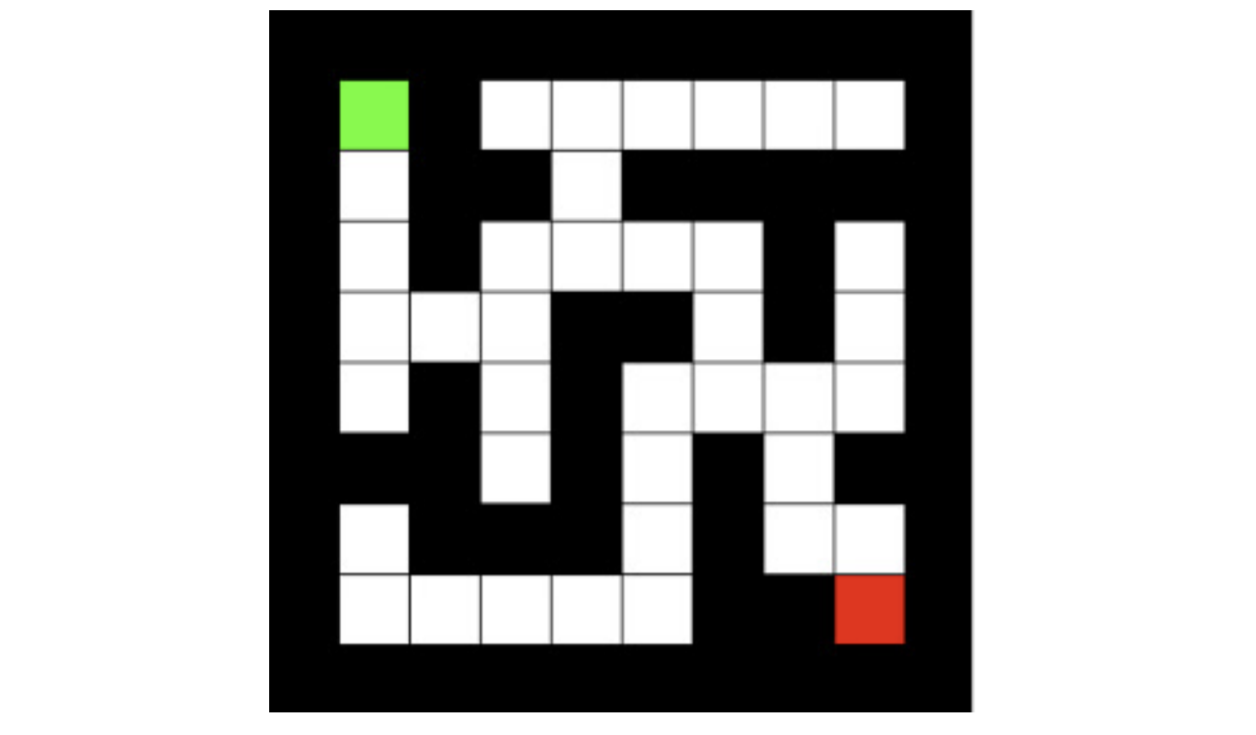

### Coding up the MDP

##### Step 1: Create a class to represent the STATE

In [4]:
#Create Class:
@dataclass(frozen=True)
class Grid_State:
    '''This class represents the spot on the grid that we are at
    Parameters:
    x : int
        This is the x coordinate measured increasingly from the top to the bottom starting at 0
    y : int
        This is the y coordinate measured positively from left to right starting at 0'''
    
    x: int
    y : int

#Prepare state action mapping for the Grid
GridMapping = StateActionMapping[Grid_State, int]

##### Step 2: Create a Finite MDP

In [5]:
class Grid_MDP_Finite(FiniteMarkovDecisionProcess[Grid_State, int]):
    def __init__(self, board_size : int, maze_grid : dict,reward_type : int):
        
        """Initialize this MDP with board size and maze grid so that we know what the range of possible 
        states are and maze dict allows us to determine the state space. A reward type of 0 means that every step gets a 
        a reward with a discount factor of 1. A reward type of 1 represents only a move into a terminal state gets a reward
        with a discount factor less than 1."""
        
        #Find the x and y board sizes:
        
        max_x, max_y = board_dimensions(maze_grid)
        self.board_size_x = max_x
        self.board_size_y = max_y
        self.maze_grid = maze_grid
        self.reward_type = reward_type
        
        super().__init__(self.get_action_transition_reward_map())
    
    def get_action_transition_reward_map(self) -> GridMapping:
        d: Dict[Grid_State, Dict[str, Categorical[Tuple[Grid_State,float]]]] = {}
        #{State:{Action 1:{(Next_State,Reward):Probability},{Action 2:{(Next_State,Reward):Probability}}}}
        action_possibilities = ["Move Up", "Move Down", "Move Left", "Move Right"]
        
        #I just realized that the board dict is set up as (y,x) so that sucks. I think I have made the correct changes...
        
        for x in range(self.board_size_x +1): #Loop through all of the x values
            for y in range(self.board_size_y +1): #Loop through all of the y values:
                
                #Determine if the state represented by (x,y) is a possible state space or not:
                if (x,y) in maze_grid.keys():
                    if self.maze_grid[(x,y)] == 'SPACE':
                        START_STATE = Grid_State(x,y)
                        action_dict = {}
                        for action in range (4): #Check all of the possible actions for that state.

                            prob_dict = {}

                            #Label actions with strings so that it is easier to read the transition map
                            action_str = action_possibilities[action]

                            #Test out all of the possible moves
                            if action == 0:      #Move UP
                                x_move = x -1
                                y_move = y
                            elif action == 1:    #Move Down
                                x_move = x + 1
                                y_move = y
                            elif action == 2:    #Move Left
                                x_move = x
                                y_move = y - 1
                            elif action == 3:    #Move Right
                                x_move = x
                                y_move = y + 1

                            #Check to see if the new state is a possible state
                            if (x_move,y_move) in maze_grid.keys():
                                if self.maze_grid[(x_move,y_move)] == 'SPACE' or self.maze_grid[(x_move,y_move)] == 'GOAL':

                                    #Declare END_STATE as the state we end up in
                                    END_STATE = Grid_State(x_move,y_move)

                                    #Determine Rewards:
                                    if self.reward_type == 0: #All movements get a reward
                                        reward = -1     
                                    elif self.reward_type == 1: #Only a movement into a terminal state gets a reward
                                        if self.maze_grid[(x_move,y_move)] == 'GOAL':
                                            reward = 1
                                        else:
                                            reward = 0

                                    #Whenever you take a possible action you always end up in a single new state
                                    prob_dict[(END_STATE,reward)] = 1
                                    action_dict[action_str] = Categorical(prob_dict)
                    d[START_STATE] = action_dict
                
                #Terminal States
                if (x,y) in maze_grid.keys():
                    if self.maze_grid[(x,y)] == 'GOAL':
                        TERMINAL_STATE = Grid_State(x,y)
                        d[TERMINAL_STATE] = None
        return d

### Step 3: Print out Transition Map for the different reward types

##### Reward per step

In [6]:
Maze_MDP_R0 = Grid_MDP_Finite(board_size = 7, maze_grid = maze_grid,reward_type = 0)

print("MDP Transition Map")
print("------------------")
print(Maze_MDP_R0)

MDP Transition Map
------------------
From State Grid_State(x=0, y=0):
  With Action Move Down:
    To [State Grid_State(x=1, y=0) and Reward -1.000] with Probability 1.000
From State Grid_State(x=0, y=2):
  With Action Move Right:
    To [State Grid_State(x=0, y=3) and Reward -1.000] with Probability 1.000
From State Grid_State(x=0, y=3):
  With Action Move Down:
    To [State Grid_State(x=1, y=3) and Reward -1.000] with Probability 1.000
  With Action Move Left:
    To [State Grid_State(x=0, y=2) and Reward -1.000] with Probability 1.000
  With Action Move Right:
    To [State Grid_State(x=0, y=4) and Reward -1.000] with Probability 1.000
From State Grid_State(x=0, y=4):
  With Action Move Left:
    To [State Grid_State(x=0, y=3) and Reward -1.000] with Probability 1.000
  With Action Move Right:
    To [State Grid_State(x=0, y=5) and Reward -1.000] with Probability 1.000
From State Grid_State(x=0, y=5):
  With Action Move Left:
    To [State Grid_State(x=0, y=4) and Reward -1.000] w

##### Reward only at terminal step

In [7]:
Maze_MDP_R1 = Grid_MDP_Finite(board_size = 7, maze_grid = maze_grid,reward_type = 1)

print("MDP Transition Map")
print("------------------")
print(Maze_MDP_R1)

MDP Transition Map
------------------
From State Grid_State(x=0, y=0):
  With Action Move Down:
    To [State Grid_State(x=1, y=0) and Reward 0.000] with Probability 1.000
From State Grid_State(x=0, y=2):
  With Action Move Right:
    To [State Grid_State(x=0, y=3) and Reward 0.000] with Probability 1.000
From State Grid_State(x=0, y=3):
  With Action Move Down:
    To [State Grid_State(x=1, y=3) and Reward 0.000] with Probability 1.000
  With Action Move Left:
    To [State Grid_State(x=0, y=2) and Reward 0.000] with Probability 1.000
  With Action Move Right:
    To [State Grid_State(x=0, y=4) and Reward 0.000] with Probability 1.000
From State Grid_State(x=0, y=4):
  With Action Move Left:
    To [State Grid_State(x=0, y=3) and Reward 0.000] with Probability 1.000
  With Action Move Right:
    To [State Grid_State(x=0, y=5) and Reward 0.000] with Probability 1.000
From State Grid_State(x=0, y=5):
  With Action Move Left:
    To [State Grid_State(x=0, y=4) and Reward 0.000] with Prob

## Problem 1 Part 2: Value Iteration

For this section I will make 2 instances of the FiniteMDP class with each testing out a different reward method. I will then measure how the value functions changes with time using the SSE from the previous value function. The results end up being 17 required iterations for each type to confirm that we have reached the value function.

R0: Rewards for each transition
   Required # of Iterations: 17
R1: Rewards for transition to terminal state
   Required # of Iterations: 17


Text(0.5, 1.0, 'Scaled SSE of Value Function between iterations')

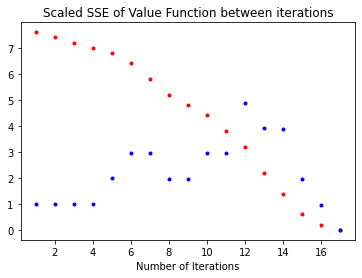

In [8]:
Values_R0 = value_iteration(Maze_MDP_R0,1)
Values_R1 = value_iteration(Maze_MDP_R1,.999)

#Set SSE = 1 to begin iterations
SSE = 1
for i,value in enumerate(Values_R0):
    if SSE == 0: #When we arrive at the optimal value function
        break
    else:
        #Prepare the initial state
        if i == 0:
            old_vf = []
            for state in value:
                old_vf.append(value[state])
            old_vf = np.array(old_vf)

        if i > 0:
            #Prepare the value function for the current iteration
            new_vf = []
            for state in value:
                new_vf.append(value[state])
            new_vf = np.array(new_vf)
            
            #Calculate SSE to determine if the value function is still changing.
            SSE = np.sum((old_vf-new_vf)**2)/5
            #SSE has been scaled so the graph is easier to read
            
            #Update Value Funciton
            old_vf = new_vf
            
            #Plot results
            plt.plot(i,SSE,'r.')
print ("R0: Rewards for each transition")
print ("   Required # of Iterations:",i-1)

#Repeat Process:

SSE = 1
for i,value in enumerate(Values_R1):
    if SSE == 0:
        break
    else:
        if i == 0:
            old_vf = []
            for state in value:
                old_vf.append(value[state])
            old_vf = np.array(old_vf)

        if i > 0:
            
            new_vf = []
            for state in value:
                new_vf.append(value[state])
            new_vf = np.array(new_vf)

            
            SSE = np.sum((old_vf-new_vf)**2)
            
            old_vf = new_vf
            
            plt.plot(i,SSE,'b.')
            
            
print ("R1: Rewards for transition to terminal state")
print ("   Required # of Iterations:",i-1)
            
plt.xlabel("Number of Iterations")
plt.title("Scaled SSE of Value Function between iterations")

#I can't get the legend to work correctly, but red is R0 and blue is R1
# plt.legend(['R0',"R1"])
# ax = plt.gca()
# leg = ax.get_legend()
# leg.legendHandles[0].set_color('red')
# leg.legendHandles[1].set_color('blue')

## Problem 1 Part 3:

Using the policy_iteration_result function I obtained the Optimal policies and Optimal value funcitions. I have printed out the policies and they are the same for both. As shown above it takes 17 iterations for both of the methods to be proven to converge. However, since this SSE of 0 is when the value function does not change, the actual optimal value function is found at **Iteration 16**. This makes sense since the longest pathway from the green space to the red space is 16 steps. 

**Time taked on this Problem 3.5 hours**

In [9]:
from pprint import pprint
VF_R0,Policies_R0 = policy_iteration_result(Maze_MDP_R0,1)
VF_R1,Policies_R1 = policy_iteration_result(Maze_MDP_R1,.99)

print ("Reward per Step:")
pprint(Policies_R0)

print ()
print ("Reward at terminal state:")
pprint(Policies_R1)

Reward per Step:
For State Grid_State(x=0, y=0):
  Do Action Move Down with Probability 1.000
For State Grid_State(x=0, y=2):
  Do Action Move Right with Probability 1.000
For State Grid_State(x=0, y=3):
  Do Action Move Down with Probability 1.000
For State Grid_State(x=0, y=4):
  Do Action Move Left with Probability 1.000
For State Grid_State(x=0, y=5):
  Do Action Move Left with Probability 1.000
For State Grid_State(x=0, y=6):
  Do Action Move Left with Probability 1.000
For State Grid_State(x=0, y=7):
  Do Action Move Left with Probability 1.000
For State Grid_State(x=1, y=0):
  Do Action Move Down with Probability 1.000
For State Grid_State(x=1, y=3):
  Do Action Move Down with Probability 1.000
For State Grid_State(x=2, y=0):
  Do Action Move Down with Probability 1.000
For State Grid_State(x=2, y=2):
  Do Action Move Right with Probability 1.000
For State Grid_State(x=2, y=3):
  Do Action Move Right with Probability 1.000
For State Grid_State(x=2, y=4):
  Do Action Move Right w

# Problem 2: Value Function Approximation:

MRP Value Function Approximation. 6 points: Consider a finite MRP with n states, specified as: (S,P, R, γ) where P represents the state-transition probability function and R represents the reward function. Assume there are no terminal states (so, N = S). Assume P is specified in the usual form as a n × n matrix, and R is specified in the usual form as a column vector of length n. We wish to approximate the value function of this MRP with a linear function based on m features that are specified as a n × m matrix Φ (each column gives a particular feature’s value for all states, and each row is the feature vector for a particular state). Give as minimal as possible conditions on the features matrix Φ such that we can exactly represent the true value function (These conditions should depend only on given values (S,P, R, γ)).

**Understanding the Problem:** ALright, so when I am a little lost on what to do to solve a problem I find it is useful to just write out what I am thinking. First I want to go through and visualize all of the parameters that go into this to help me understand how some of the matrix math is going to work out. First we have our *State Space* which is just a list from $s_1 \to s_n$ where all the states are non terminal. I don't know if this means that every state has some non zero probability of going to every other state, or if each state will have just a few other states it can go to.

\begin{equation}
\mathcal{S} = \{s_1,s_2,s_3,...,s_n\}
\end{equation}

Next I have the *State Transition Probability Matrix* which hold values between 0 and 1 and represent the probabilities that a specific starting state can go to some next state. All of the possible state to state jumps are included in this matrix as it is $n\times n$. 

\begin{gather}
\mathcal{P} = 
\begin{bmatrix}
\mathcal{P}_{11} & \dots & \mathcal{P}_{1n} \\
\vdots & & \vdots \\
\mathcal{P}_{n1} & \dots & \mathcal{P}_{nn}
\end{bmatrix}
\end{gather}

From here we have the *Reward Column Matrix* where it is the same length as each of the states. This reward matrix holds the Reward for leaving the state that it represents. I have seen some places that it is also represented as the reward for going into a state, but I think that the first definition is more consistent with the material we are learning in this class. 

\begin{gather}
\mathcal{R}= 
\begin{bmatrix}
\mathcal{R}_{1} \\
\vdots \\
\mathcal{R}_{n}
\end{bmatrix}
\end{gather}

$\gamma$ is the dicount factor and really doesn't deserve it's own visual representation yet. It tells us how much we value future rewards, but I will bring it back when I write out the value funciton. Actually let's do that now as it is the next step in this. We can represent the value function as 

$v(s) = E[G_t |\mathcal{S}_t =s]$ Start with the value function with reward $G_t$:

$v(s) = E[ R_{t+1} + \gamma R_{t+2} + \gamma^2 R_{t+3} + \gamma^3 R_{t+4} + ...|\mathcal{S}_t =s]$ Replace return with formula

$v(s) = E[ R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + \gamma^2 R_{t+4} + ...)|\mathcal{S}_t =s]$ Factor out a gamma

$v(s) = E[ R_{t+1} + \gamma (R_{t+2} + \gamma R_{t+3} + \gamma^2 R_{t+4} + ...)|\mathcal{S}_t =s]$ Oh hey look the return function has comeback but not it is the return for the next state

$v(s) = E[ R_{t+1} + \gamma G_{t+1}|\mathcal{S}_t =s]$ Replace return with G_t+1

$v(s) = E[ R_{t+1} + \gamma v(\mathcal{S}_{t+1})|\mathcal{S}_t =s]$ Since we are in an expectation already we can replace the return with the value function for the next state

Now we have a recursive function that allows us to calculate the value function of a state as a function of the value function of the next state. We can understand how to use the Bellman equation is used with matricies and the probability transition matrix. The equation is summarized as:

$v = R + \gamma \mathcal{P}v$

\begin{gather}
\begin{bmatrix}
v(1) \\ \vdots \\ v(n)
\end{bmatrix} =
\begin{bmatrix}
R_1\\ \vdots \\ R_n
\end{bmatrix} + \gamma
\begin{bmatrix}
\mathcal{P}_{11} & \dots & \mathcal{P}_{1n} \\
\vdots & & \vdots \\
\mathcal{P}_{n1} & \dots & \mathcal{P}_{nn}
\end{bmatrix}
\begin{bmatrix}
v(1) \\ \vdots \\ v(n)
\end{bmatrix}
\end{gather}

The reward matrix tells us what the reward is for exiting that state. **The Bellman equation is a linear equation and so it can be solved directly!**

### Solution to the Bellman Equation: (Solving the value function for all states)

$v = R + \gamma \mathcal{P}v$ Starting with the previous matrix form...

$(1-\gamma\mathcal{P})v = R$: bring over coefficients of the value function

$v = (1-\gamma\mathcal{P})^{-1} R$ solve for v since this is a linear equation

We can solve this directly assuming that the matrix isn't super large. That is because solving this means inverting the $(1-\gamma\mathcal{P})$ matrix and multiplying it to the rewards matrix.

--------------------------------------------------------------------------------------

Now I want to get into the actual core of the problem which is the feature vector $\phi$ that will be used in linear approximation to calculate the value function. Soooo, yeah, I'm not going to lie, I am a little confused on how we determine the minimal as possible conditions on the feature vector, as it seems like we build this feature vector to represent components of a state that can not be easily defined. So how are we building it as a function of the remaining parameters and not the environment? Like, idk, but we are on an adventure to try and figure it out. So anyway, the feature VECTOR is a vector (big surprise) for a SINGLE state that represents conditions of the environment that we deem important to the state. Like for example, if we were a robot and we are moving around in a box we might have features like distance to the left wall, distance to the right wall, or slope of the floor. We try an capture the environment through these "features" since we can't get all of the possible parameters for a complex environment. We also don't care about all of the parameters, like the robot doesn't care if the floor is blue if the goal we are trying to solve for is to navigate. The feature vector looks like:

\begin{gather}
\phi(s) = 
\begin{bmatrix}
\phi_{1}(s) & \phi_{2}(s) & \phi_{3}(s) & \dots & \phi_{m}(s)
\end{bmatrix}
\end{gather}

However we are dealing with the Feature MATRIX which (big surprise part II) is a matrix. Effectively it is the collection of the feature vector of each of the states stacked on top of each other. thus it looks like this

\begin{gather}
\phi = 
\begin{bmatrix}
\phi_{1}(s_1) & \phi_{2}(s_1) & \phi_{3}(s_1) & \dots & \phi_{m}(s_1) \\
\phi_{1}(s_2) & \phi_{2}(s_2) & \phi_{3}(s_2) & \dots & \phi_{m}(s_2) \\
\phi_{1}(s_3) & \phi_{2}(s_3) & \phi_{3}(s_3) & \dots & \phi_{m}(s_3) \\
\vdots &  & & \dots &  \vdots \\
\phi_{1}(s_n) & \phi_{2}(s_n) & \phi_{3}(s_n) & \dots & \phi_{m}(s_n) \\
\end{bmatrix}
\end{gather}

So how do we actually use this feature vector to get the value function? Well I will tell you, me. We utilize a weight vector that has the same length as the number of features. in other words for each of the features (assuming that the features are numbers) we multiply that feature by some weighted value that tells us how important this feature is. this can be expressed like this for a SINGLE state (calculate the value function for 1 state using the feature vector and weight vector:

\begin{equation}
v(s,w) = \phi(s)^T \cdot w = \sum_j \phi_j(s) w_j
\end{equation}

So now we need to actually build $\phi$, but in the case of the problem we need this feature vector to exactly solve the value function. And we want to do it with as few conditions as possible. 

**Solution:**

So, I think that the way to approach this problem is with eigenvalue decomposition. Like, the way that we solve for the true value function is by inverting a matrix. And then multiplying by the Reward Vector. Now, we could use eigenvalue decomposition to obtain the solution to the inverse matrix. The eigenvalues in this case act like the weights that we would fit and then the Reward vector would be our feature vector. Thus for us to map the value function exactly we would need m = n number of features which represent the n eigenvalues of an $n \times n$ matrix. 

Okkayyy, so that is not what the question is asking for apparently. Honestly, this question is still super confusing, and I don't really have too much more time to work on it. As some closing comments, we could solve for the eigenvalues of the $(1-\gamma \mathcal{P})$ term using eigenvalue decomposition. we can then invert the diagonal eigenvalue matrix by inverting each term on the diagonal, and finally multiply it to The Reward Matrix To get a linear soluion to the value function. I don't get what the problem means by conditions on phi, like we are making rules on what the feature vector can be based on different Input Matricies. Like if the Rewards are all 0 then the value function everywhere is zero, so we could have just one feature in that case that represents reward, and the weights are any number. 

# Problem 3: Career Optimization

##### Understanding the problem:

Alright, I'm not gonna lie these problems are really fun to solve, but man is this a long problem... Any who, let's see if I understand this problem. Okay, so we have H hours in a day, so we will specify H in the MDP. Next we can break our day up into different actions. Thus our action space is broken up into integer amounts of hours to work in a certain section. Thus a sigle action is represented by 3 numbers. For each day we get a base reward of the number of hours we worked times the hours that we actually did work. Makes sense. We also have an integer wage that can only increase to some maximum wage (we will need to specifiy this as well). We can get a pay increase according to a poisson distribuiton based on the number of hours we spend learning and some random alpha variable (which we will need to specify). Okay, next we have ... why tho... why add this to the problem :( anyway we have another option of getting a job offer with probability of $\frac{\beta \cdot s}{H}$ that inceases our wage by 1 if it isn't already the max wage. So in this case anytime we are offered a job we will take it. thus we can represent this as its own transition probability. Also we have a discount of $\gamma = .95$

**Parameters:**

H : int (hours in a day) 

W : int (Max obtainable wage)

$\alpha$ : float (multiplying factor for poisson distribution)

$\beta$ : float (some value bewteen 0 and 1 that affects how often we get job offers)

$\gamma$ : float (value between 0 and 1 that represents the discount factor)

**State:**

w : current wage

**Action:**

learn : time spent learning

search : time spent searching

work : Time working

This problem is kinda weird since one of our actions is always dictated for us. like we always pick the higher wage, which makes sense, but its odd that we dont let the MDP learn to do that. (tis  a trick to throw us off)

**State Space:**

So the state space is represented by whatever integer wage we currently have. 

$\mathcal{S} = \{1,2,...,W\}$

**Action Space:**

The only actions that we can take are deciding what hours to learn, search, and work each day. However, this should not be thought of as 3 individual actions, but 1 action that is composed of multiple parts. For example a single action for a 10 hour day would be to learn for 1 hour, search for 2 hours and work for 7 hours. Thus the action space is a reflection of the number of permutations of (s, l, H-s-l) where the 3 numbers sum to H. For H = 3 this would be {(3,0,0) (0,3,0) (0,0,3) (2,1,0) (0,2,1) (1,0,2) (1,2,0) (0,1,2) (2,0,1) (1,1,1)}. I'm not exactly sure how to write permutations in a general form:

$\mathcal{A} = $ {Permutations(Pick 3, sum to H)}

The actions for a specific state are the same as for the rest of the states. 

**Reward Space:**

In the reward space the reward for the day will always be the wage that we have times the number of hours we choose to work. Ths the optimization problem becomes how fast can we maximize our wage. I think that I need to break this up into multiple rewards. like a base reward for having a certain wage and then an additional reward for changing jobs or getting a promotion. Thus we break this reward into an action reward and a transition reward.  

Reward for taking an action: $\mathcal{R}^a = \{w*l\}$ 

Once we have taken a reward we now have probabilities of being thrown into new states. These probabilities break down into wage increases with a new possible state that goes from w to W since x can get you all the way up to W, but the probability is extremely low. There are also the possibilities of getting offered a new job.

Reward for getting a new wage: $\mathcal{R}^a(s'|s) = \{wage(s')\}$ for $a \in \mathcal{A}$

**State-Transition Probabilities:**

The probability mapping is probably the toughest part of this question as there are different avenues to get the same state. Specifically the same wage and wage + 1 states. 

\begin{gather}
\mathcal{P}^a(s'|s) = \left\{
\begin{array}{ll}
    \left( \textrm{PMF of Poisson } (\lambda = \alpha \times learn(a), k = \textrm{wage}(s')) +  1 - \frac{B*search(a)}{H} \right)/2 & \textrm{if wage(s') = wage (s)} \\
    \left( \textrm{PMF of Poisson } (\lambda = \alpha \times learn(a), k = \textrm{wage}(s')) + \frac{B*search(a)}{H} \right)/2 & \textrm{if wage(s') = wage (s) + 1} \\
    \left( 1 - \textrm{CDF of Poisson } (\lambda = \alpha \times learn(a), k = \textrm{wage}(s')) \right)/2 & \textrm{if wage(s') = W} \\
    \left( \textrm{PMF of Poisson } (\lambda = \alpha \times learn(a), k = \textrm{wage}(s')) \right)/2 & \textrm{else}
\end{array}
\right\}
\end{gather}

I think that this mapping is probabily best explained with a picture, so below is how I came up with these probabilities. Effectively for the first two new states there are 2 ways to get to them and so they have combined probabilitites. All of the rest of the states only depend on the poisson contributions since they are the only way to get a higher wage than w + 1, however with alpha = .08 there is almost no way to get up that high for most states. The probability to get to any state becomes the average probability of any method to get to that state. 


**Discount Factor:**

I don't really know what I am suppose to say here. $\gamma$ has to be less than 1 or the system will never solve iteratively. $\gamma$ can be zero, but it means we dont care about future rewards at all and it takes away from the usefulness of the problem. But it can still be zero thus:

$\gamma \in [0,1)$

meaning $\gamma$ can be anywhere between 0 and include zero and 1, but not inclue 1.

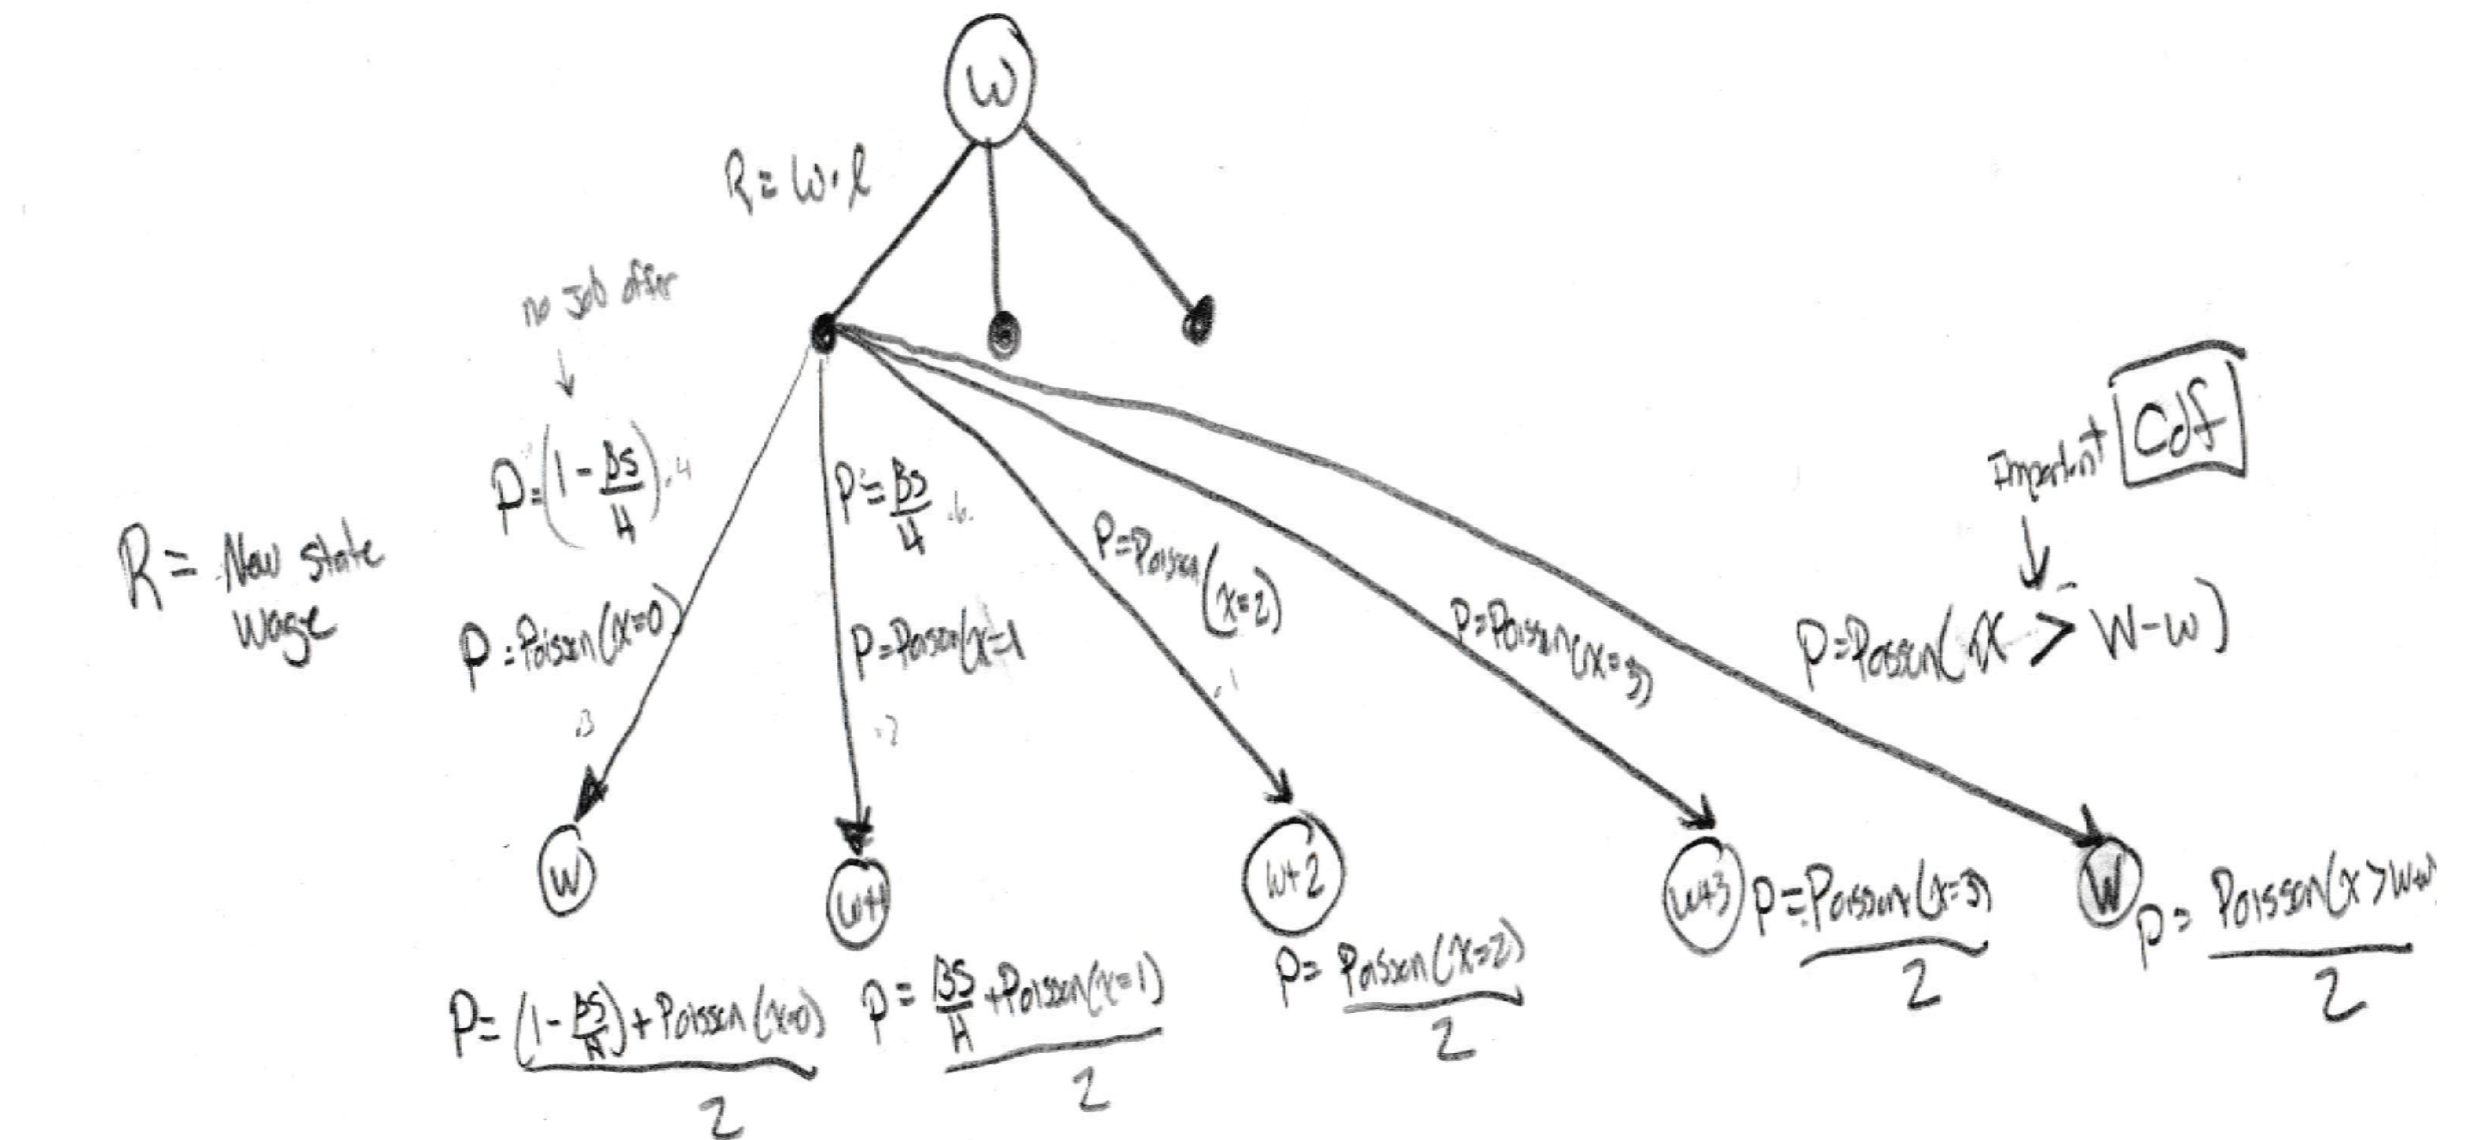

## Problem 3 Part 2: Implement MDP

##### Create an wage class

In [10]:
from scipy.stats import poisson

@dataclass(frozen=True)
class Wage_State:
    wage: int
    

WageMapping = StateActionMapping[Wage_State, int]

##### Step 2: Create function to generate a list of all the possible action combinations:



In [18]:
#Taken from Stack Overflow: https://stackoverflow.com/questions/7748442/generate-all-possible-lists-of-length-n-that-sum-to-s-in-python
def sums(length, total_sum):
    if length == 1:
        yield (total_sum,)
    else:
        for value in range(total_sum + 1):
            for permutation in sums(length - 1, total_sum - value):
                yield (value,) + permutation

##### Create a Finite MDP Class

In [12]:
from more_itertools import distinct_permutations

class Employment_MDP_Finite(FiniteMarkovDecisionProcess[Wage_State, int]):
    def __init__(self, available_hours : int, max_wage : int, promotion_param_alpha : float, job_offer_param_beta: float):
        
        """Initialize this MDP with available hours, max wage and the alpha and beta parameters"""
        
        #Find the x and y board sizes:
        
        self.H = available_hours
        self.W = max_wage
        self.alpha = promotion_param_alpha
        self.beta = job_offer_param_beta
        self.possible_actions = list(sums(3,self.H))

        
        super().__init__(self.get_action_transition_reward_map())
    
    def get_action_transition_reward_map(self) -> GridMapping:
        d: Dict[Grid_State, Dict[str, Categorical[Tuple[Grid_State,float]]]] = {}
        #{State:{Action 1:{(Next_State,Reward):Probability},{Action 2:{(Next_State,Reward):Probability}}}}
        
        #Loop through all of the possible states (Wages)
        for wage in range(1,self.W + 1):
            START_STATE = Wage_State(wage) 
            action_dict = {}
            #print ("Starting Wage:",wage)
            
            #Loop through all the possible actions:
            for actions in self.possible_actions:
                learn_time = actions[0]
                search_time = actions[1]
                work_time = actions[2]
                
                BASE_REWARD = work_time * wage
                
                action_str = "Learn for " + str(learn_time) + " hrs.  Search for " + str(search_time) + " hrs.  Work for " + str(work_time) + " hrs."
                
                prob_dict = {}
                
                #Determine All of the new states that we can end up in: (This is any wage equal to or greater than our current wage)
                for new_wage in range(wage,self.W+1):
                    END_STATE = Wage_State(new_wage)
                    poisson_distr = poisson(self.alpha * learn_time)
                    
                    #Determine Probability of ending up in this new state:
                    if new_wage == wage:
                        P_no_job_offer = 1 - self.beta*search_time/self.H
                        P_no_wage_increase = poisson_distr.pmf(new_wage-wage)
                        
                        Probability = (P_no_job_offer + P_no_wage_increase)/2

                    elif new_wage == wage + 1:
                        P_job_offer = self.beta*search_time/self.H
                        P_wage_increase_by_1 = poisson_distr.pmf(new_wage-wage)
                        
                        Probability = (P_job_offer + P_wage_increase_by_1)/2
                        
                    elif new_wage == self.W:
                        Probability = (1 - poisson_distr.cdf(self.W-wage))/2
                        
                    else:
                        Probability = poisson_distr.pmf(new_wage-wage)/2
                        
                        
                    #Rewards:
                    Reward = BASE_REWARD + new_wage
                    
                    prob_dict[(END_STATE,Reward)] = Probability 
                    
                action_dict[action_str] = Categorical(prob_dict)
            d[START_STATE] = action_dict
        return d


In [16]:
Employment_MDP = Employment_MDP_Finite( available_hours=10, max_wage =30, promotion_param_alpha =.08, job_offer_param_beta= .82)

print("MDP Transition Map")
print("------------------")
#print(Employment_MDP)

MDP Transition Map
------------------


### Use Value Iteration to solve the MDP:

[ 817.12220903  916.84359634 1026.53845929 1147.45449436 1280.99641538
 1428.74780737 1592.42278046 1773.7634906  1979.88408218 2199.87120243
 2419.85832267 2639.84544291 2859.83256315 3079.8196834  3299.80680364
 3519.79392388 3739.78104412 3959.76816437 4179.75528461 4399.74240485
 4619.72952509 4839.71664534 5059.70376558 5279.69088582 5499.67800606
 5719.66512631 5939.65224655 6159.63936679 6379.62648703 6599.61360728]


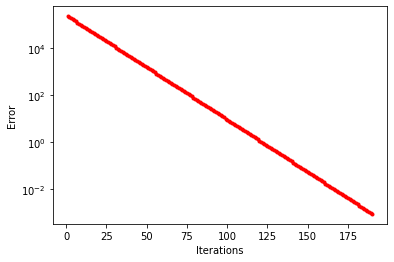

In [14]:
Values = value_iteration(Employment_MDP,.95)

#Set SSE = 1 to begin iterations
SSE = 1
for i,value in enumerate(Values):
    if SSE <= 0.001: #When we arrive at the optimal value function
        print (new_vf)
        break
    else:
        #Prepare the initial state
        if i == 0:
            old_vf = []
            for state in value:
                old_vf.append(value[state])
            old_vf = np.array(old_vf)

        if i > 0:
            #Prepare the value function for the current iteration
            new_vf = []
            for state in value:
                new_vf.append(value[state])
            new_vf = np.array(new_vf)
            
            #Calculate SSE to determine if the value function is still changing.
            SSE = np.sum((old_vf-new_vf)**2)/5
            #SSE has been scaled so the graph is easier to read
            
            #Update Value Funciton
            old_vf = new_vf
            
            #Plot results
            plt.semilogy(i,SSE,'r.')
            plt.xlabel("Iterations")
            plt.ylabel("Error")

In [17]:
VF,Policies = policy_iteration_result(Employment_MDP,.95)
print ("Optimal Value Funciton")
pprint(VF)
print ()
print ("Optimal Policy")
pprint(Policies)

Optimal Value Funciton
{Wage_State(wage=2): 916.9605928555605,
 Wage_State(wage=1): 817.2392055461122,
 Wage_State(wage=16): 3519.999895978943,
 Wage_State(wage=23): 5059.999850469731,
 Wage_State(wage=27): 5939.999824464468,
 Wage_State(wage=25): 5499.999837467097,
 Wage_State(wage=26): 5719.999830965781,
 Wage_State(wage=24): 5279.999843968413,
 Wage_State(wage=22): 4839.999856971047,
 Wage_State(wage=19): 4179.999876474996,
 Wage_State(wage=20): 4399.999869973677,
 Wage_State(wage=29): 6379.999811461834,
 Wage_State(wage=28): 6159.9998179631475,
 Wage_State(wage=21): 4619.999863472362,
 Wage_State(wage=17): 3739.999889477626,
 Wage_State(wage=18): 3959.9998829763113,
 Wage_State(wage=3): 1026.6554558390897,
 Wage_State(wage=4): 1147.5714908033372,
 Wage_State(wage=5): 1281.1134095300074,
 Wage_State(wage=15): 3299.9999024802587,
 Wage_State(wage=6): 1428.864803711741,
 Wage_State(wage=7): 1592.5399984835287,
 Wage_State(wage=8): 1773.8793499068136,
 Wage_State(wage=9): 1979.99994148

### Explanation for Optimal Policy:

This policy makes complete sense since you would want to try and get up to a reasonable wage before you value the money that you get from working. It also makes sense that we spend the early time learning since we obtain a higher expected reward than searching near the start. What's also important is the effect of $\gamma$ on the wage at which you switch to searching and then working full time. The closer $\gamma$ is to 1 the more valuable it is to continue to search for a higher wage before working full time. This makes sense because $\gamma$ is a way of measuring how far into the future we care about the rewards that we are getting then. As $\gamma$ gets smaller we value the money that would be getting in the near future way more and so the optimal policy actually shifts to working full time at a much lower wage. In fact if we take $\gamma$ to 0 then the optimal policy is to work no matter the wage, which makes sense since we don't really care about future rewards and just want to make money now.